## Confidentiality

This notebook is downloaded from Tensorflow and is for demonstrational purposes only.

Please do not copy or distribute this notebook.

# Loading images

In this notebook the loading and preprocessing of an image dataset is described in three ways. First, high-level Keras preprocessing [utilities](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) and [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) are used to read a directory of images on disk. Next, a pipeline is described from scratch using [tf.data](https://www.tensorflow.org/guide/data). Finally, a dataset is downloaded from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [ ]:
import numpy as np
import json, math, os, sys
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.3.0


### Downloading the flowers dataset

In this notebook, a dataset of several thousand photos of flowers is used. The flowers dataset contains 5 sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


After downloading (218MB), a copy of the flower photos is available. There are 3670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

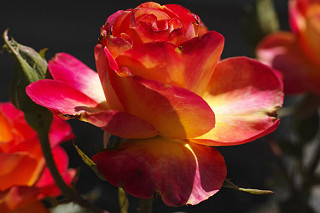

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

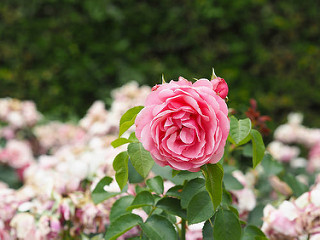

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Loading using keras.preprocessing

Let's load these images off disk using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

### Creating a dataset

Defining some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing the model. You can use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


The class names can be found in the `class_names` attribute on these datasets.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualizing the data

Here are the first 9 images from the training dataset.

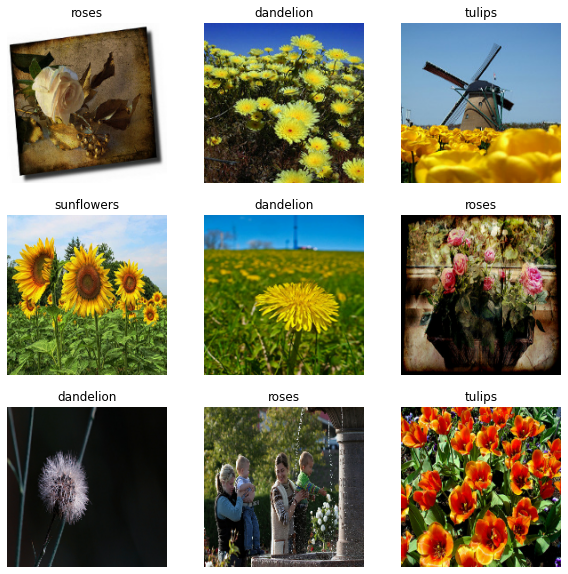

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to `model.fit`. You can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 


Note: you can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardizing the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, values are standardized to be in the `[0, 1]` by using a Rescaling layer.

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96902645


*Or*, you can include the layer inside your model definition to simplify deployment. The second approach is used here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `Rescaling(1./127.5, offset=-1)`

Note: Previously images are resized using the `image_size` argument of `image_dataset_from_directory`. 


### Configuring the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you can use when loading data.

`.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. If the dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`.prefetch()` overlaps data preprocessing and model execution while training. 

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Training a model

For completeness, Here's showed how to train a simple model using the datasets that are prepared. This model has not been tuned in any way - the goal is to show the mechanics using the datasets, you just created.

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])



Note: There's only trained for a few epochs, so this notebook runs quickly. 

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 9s 93ms/step - loss: 1.2757 - accuracy: 0.4584 - val_loss: 1.0598 - val_accuracy: 0.5790
Epoch 2/3
92/92 [==============================] - 3s 32ms/step - loss: 1.0202 - accuracy: 0.5981 - val_loss: 0.9992 - val_accuracy: 0.5940
Epoch 3/3
92/92 [==============================] - 3s 32ms/step - loss: 0.8725 - accuracy: 0.6628 - val_loss: 0.9362 - val_accuracy: 0.6308


Note: you can also write a custom training loop instead of using `model.fit`. 

The validation accuracy is low compared to the training accuracy, indicating the model is overfitting. 

## Using tf.data for finer control

The above keras.preprocessing utilities are a convenient way to create a `tf.data.Dataset` from a directory of images. For finer grain control, you can write a custom input pipeline using `tf.data`. 

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/7950901292_2dea05f9a2_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/20777375650_ef854bf645.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/8978962053_0727b41d26.jpg'
b'/root/.keras/datasets/flower_photos/tulips/4571353297_5634177744_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/9244082319_b1f7e2d8b0_n.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Splitting the dataset into train and validation:

In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

You can see the length of each dataset as follows:

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Writing a short function that converts a file path to an `(img, label)` pair:

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Using `Dataset.map` to create a dataset of `image, label` pairs:

In [ ]:
# Settng `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


### Configuring dataset for performance

To training a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. 

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualizing the data

You can visualize this dataset similarly to the one you created previously.

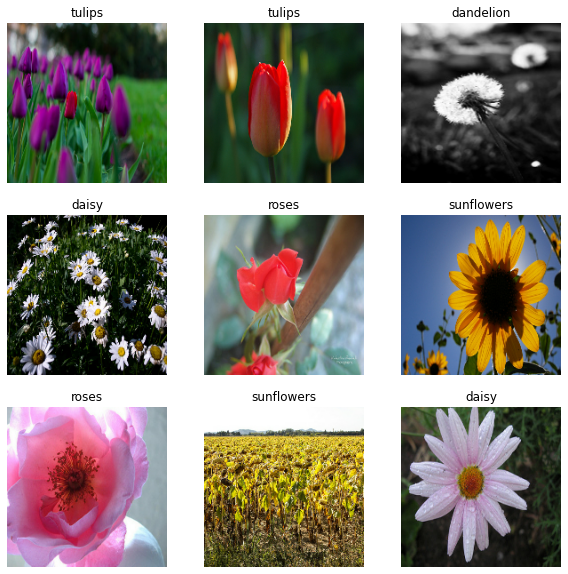

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continuing training the model

You have now manually built a similar `tf.data.Dataset` to the one created by the `keras.preprocessing` above. You can continue training the model with it. As before, there's trained for just a few epochs to keep the running time short.

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 10s 107ms/step - loss: 0.7680 - accuracy: 0.7091 - val_loss: 0.7441 - val_accuracy: 0.7180
Epoch 2/3
92/92 [==============================] - 3s 35ms/step - loss: 0.5820 - accuracy: 0.7769 - val_loss: 0.7494 - val_accuracy: 0.7180
Epoch 3/3
92/92 [==============================] - 3s 35ms/step - loss: 0.4558 - accuracy: 0.8304 - val_loss: 0.7946 - val_accuracy: 0.7289


## Using TensorFlow Datasets

So far, there's focused on loading data off disk. You can also find a dataset to use by exploring the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) of easy-to-download datasets at [TensorFlow Datasets](https://www.tensorflow.org/datasets). Previously the Flowers dataset is loaded off disk, next let's import with TensorFlow Datasets. 

Downloading the flowers [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) using TensorFlow Datasets.

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


The flowers dataset has five classes.

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


 Retrieving an image from the dataset.

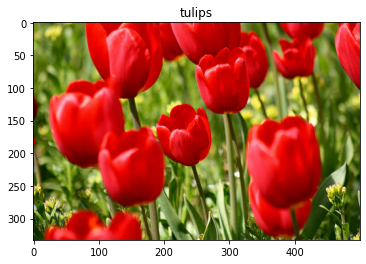

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

As before, remember to batch, shuffle, and configure each dataset for performance.

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)